# Fingernails AlexNet_like Implementation

In [23]:
import os
import zipfile
import gdown
import cv2
import numpy as np
from PIL import Image
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt


In [24]:
file_id = "1ZjjaB7bb5T1_WomcFtSCn-jPtOl1UjIJ"
url = f"https://drive.google.com/uc?id={file_id}"
zip_path = "fingernails_dataset.zip"
extract_dir = "unzipped_dataset"

gdown.download(url, zip_path, quiet=False)
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)



Downloading...
From (original): https://drive.google.com/uc?id=1ZjjaB7bb5T1_WomcFtSCn-jPtOl1UjIJ
From (redirected): https://drive.google.com/uc?id=1ZjjaB7bb5T1_WomcFtSCn-jPtOl1UjIJ&confirm=t&uuid=57ffb97d-c525-43cc-bec0-05c2e0df9363
To: /content/fingernails_dataset.zip
100%|██████████| 27.9M/27.9M [00:00<00:00, 43.0MB/s]


In [25]:
dataset_folder = os.path.join(extract_dir, "Fingernails")
anemic_data = []
non_anemic_data = []

for filename in os.listdir(dataset_folder):
    filepath = os.path.join(dataset_folder, filename)
    img = cv2.imread(filepath)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img_rgb)
        if filename.startswith("Anemic"):
            anemic_data.append((pil_img, 0))
        else:
            non_anemic_data.append((pil_img, 1))

all_data = anemic_data + non_anemic_data
random.shuffle(all_data)

images, labels = zip(*all_data)
labels = np.array(labels)


In [26]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

print("Train set:", np.unique(train_labels, return_counts=True))
print("Test set:", np.unique(test_labels, return_counts=True))


Train set: (array([0, 1]), array([2017, 1391]))
Test set: (array([0, 1]), array([504, 348]))


In [28]:
def rotate_image(image, angle):
    return image.rotate(angle)

def flip_horizontal(image):
    return image.transpose(Image.FLIP_LEFT_RIGHT)

def flip_vertical(image):
    return image.transpose(Image.FLIP_TOP_BOTTOM)

def translate_image(image, shift_x=10, shift_y=10):
    img_np = np.array(image)
    rows, cols, _ = img_np.shape
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    dst = cv2.warpAffine(img_np, M, (cols, rows))
    return Image.fromarray(dst)

In [27]:
class AugmentedDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, shuffle=True, augment=False):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.images[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        processed_images = []

        for img in batch_images:
            if self.augment:
                if random.random() < 0.25:
                    img = rotate_image(img, angle=random.choice([90, 180, 270]))
                if random.random() < 0.25:
                    img = flip_horizontal(img)
                if random.random() < 0.25:
                    img = flip_vertical(img)
                if random.random() < 0.25:
                    img = translate_image(img)

            img = img.resize((224, 224))
            img_array = np.array(img) / 255.0
            processed_images.append(img_array)

        return np.array(processed_images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.images, self.labels))
            random.shuffle(temp)
            self.images, self.labels = zip(*temp)


In [12]:
model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), input_shape=(224, 224, 3), padding='same'), Activation('relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(256, (5, 5), padding='same'), Activation('relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(384, (3, 3), padding='same'), Activation('relu'),
    Conv2D(384, (3, 3), padding='same'), Activation('relu'),
    Conv2D(256, (3, 3), padding='same'), Activation('relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(4096), Activation('relu'), Dropout(0.5),
    Dense(4096), Activation('relu'), Dropout(0.5),
    Dense(1), Activation('sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(
    optimizer=SGD(learning_rate=0.01, decay=0.0001, momentum=0.9),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

batch_size = 32
train_gen = AugmentedDataGenerator(train_imgs, train_labels, batch_size=batch_size, augment=True)
test_gen = AugmentedDataGenerator(test_imgs, test_labels, batch_size=batch_size, augment=False)

history = model.fit(train_gen, validation_data=test_gen, epochs=10)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 34s 238ms/step - accuracy: 0.5758 - loss: 0.6827 - val_accuracy: 0.5915 - val_loss: 0.6805
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.5908 - loss: 0.6794 - val_accuracy: 0.5915 - val_loss: 0.6777
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.5826 - loss: 0.6820 - val_accuracy: 0.5915 - val_loss: 0.6763
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - accuracy: 0.5986 - loss: 0.6731 - val_accuracy: 0.5915 - val_loss: 0.6764
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.5902 - loss: 0.6774 - val_accuracy: 0.5915 - val_loss: 0.6764
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.5869 - loss: 0.6780 - val_accuracy: 0.5915 - val_loss: 0.6778
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.5995 - loss: 0.6736 - val_accuracy: 0.5915 - val_loss: 0.6763
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.5959 - loss: 0.6753 - val

In [36]:
predictions = model.predict(test_gen)
y_pred = (predictions > 0.405).astype(int).flatten()
y_true = np.array(test_labels)

print("Prediction distribution:", np.unique(y_pred, return_counts=True))
print("Sample raw prediction values:", predictions[:10])

conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Anemic", "Non-Anemic"])
auc = roc_auc_score(y_true, predictions)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', report)
print(f'AUC: {auc:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step
Prediction distribution: (array([0, 1]), array([348, 504]))
Sample raw prediction values: [[0.40409476]
 [0.4083445 ]
 [0.40532205]
 [0.4072681 ]
 [0.4044845 ]
 [0.4067833 ]
 [0.40491056]
 [0.40393355]
 [0.4047281 ]
 [0.40626857]]
Confusion Matrix:
 [[202 302]
 [146 202]]
Classification Report:
               precision    recall  f1-score   support

      Anemic       0.58      0.40      0.47       504
  Non-Anemic       0.40      0.58      0.47       348

    accuracy                           0.47       852
   macro avg       0.49      0.49      0.47       852
weighted avg       0.51      0.47      0.47       852

AUC: 0.5104
F1-Score: 0.4742
Precision: 0.4008
Recall: 0.5805


In [29]:
from sklearn.model_selection import KFold
import numpy as np

# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Track metrics for each fold
fold_accuracies = []
fold_losses = []
fold_auc = []
fold_f1 = []
fold_precision = []
fold_recall = []

# Start 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(images), 1):
    print(f"Training fold {fold}...")

    # Split data into train and validation based on the current fold's indices
    train_imgs_fold = [images[i] for i in train_idx]
    train_labels_fold = labels[train_idx]
    val_imgs_fold = [images[i] for i in val_idx]
    val_labels_fold = labels[val_idx]

    # Initialize data generators for current fold
    train_gen = AugmentedDataGenerator(train_imgs_fold, train_labels_fold, batch_size=batch_size, augment=True)
    val_gen = AugmentedDataGenerator(val_imgs_fold, val_labels_fold, batch_size=batch_size, augment=False)

    # Initialize the model (or reinitialize it to avoid weight carryover from previous folds)
    model = Sequential([
        Conv2D(96, (11, 11), strides=(4, 4), input_shape=(224, 224, 3), padding='same'), Activation('relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        Conv2D(256, (5, 5), padding='same'), Activation('relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        Conv2D(384, (3, 3), padding='same'), Activation('relu'),
        Conv2D(384, (3, 3), padding='same'), Activation('relu'),
        Conv2D(256, (3, 3), padding='same'), Activation('relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        Flatten(),
        Dense(4096), Activation('relu'), Dropout(0.5),
        Dense(4096), Activation('relu'), Dropout(0.5),
        Dense(1), Activation('sigmoid')
    ])

    model.compile(
        optimizer=SGD(learning_rate=0.01, decay=0.0001, momentum=0.9),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train the model for the current fold
    history = model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)

    # Evaluate model on the validation set
    val_predictions = model.predict(val_gen)
    val_y_pred = (val_predictions > 0.5).astype(int).flatten()

    # Calculate metrics for this fold
    auc = roc_auc_score(val_labels_fold, val_predictions)
    f1 = f1_score(val_labels_fold, val_y_pred)
    precision = precision_score(val_labels_fold, val_y_pred)
    recall = recall_score(val_labels_fold, val_y_pred)
    acc = history.history['accuracy'][-1]
    loss = history.history['loss'][-1]

    # Store metrics for this fold
    fold_accuracies.append(acc)
    fold_losses.append(loss)
    fold_auc.append(auc)
    fold_f1.append(f1)
    fold_precision.append(precision)
    fold_recall.append(recall)

    print(f"Fold {fold} results - AUC: {auc:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {acc:.4f}, Loss: {loss:.4f}")

# After all folds are done, print the average metrics across all folds
print("\nAverage results after 10-fold cross-validation:")
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Average Loss: {np.mean(fold_losses):.4f}")
print(f"Average AUC: {np.mean(fold_auc):.4f}")
print(f"Average F1-Score: {np.mean(fold_f1):.4f}")
print(f"Average Precision: {np.mean(fold_precision):.4f}")
print(f"Average Recall: {np.mean(fold_recall):.4f}")


Training fold 1...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 27s 195ms/step - accuracy: 0.5938 - loss: 0.6794 - val_accuracy: 0.5610 - val_loss: 0.6871
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.5954 - loss: 0.6758 - val_accuracy: 0.5610 - val_loss: 0.6874
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.5857 - loss: 0.6789 - val_accuracy: 0.5610 - val_loss: 0.6887
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.5910 - loss: 0.6769 - val_accuracy: 0.5610 - val_loss: 0.6871
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.5904 - loss: 0.6774 - val_accuracy: 0.5610 - val_loss: 0.6877
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.5858 - loss: 0.6789 - val_accuracy: 0.5610 - val_loss: 0.6905
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.6011 - loss: 0.6731 - val_accuracy: 0.5610 - val_loss: 0.6870
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.6013 - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwar

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.6003 - loss: 0.6765 - val_accuracy: 0.5798 - val_loss: 0.6803
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.5893 - loss: 0.6776 - val_accuracy: 0.5798 - val_loss: 0.6851
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.6029 - loss: 0.6712 - val_accuracy: 0.5798 - val_loss: 0.6803
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.5911 - loss: 0.6766 - val_accuracy: 0.5798 - val_loss: 0.6809
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.6082 - loss: 0.6694 - val_accuracy: 0.5798 - val_loss: 0.6805
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.5865 - loss: 0.6785 - val_accuracy: 0.5798 - val_loss: 0.6818
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.5886 - loss: 0.6785 - val_accuracy: 0.5798 - val_loss: 0.6803
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.5911 - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwar

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.5802 - loss: 0.6835 - val_accuracy: 0.6338 - val_loss: 0.6633
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.5682 - loss: 0.6847 - val_accuracy: 0.6338 - val_loss: 0.6577
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.5940 - loss: 0.6763 - val_accuracy: 0.6338 - val_loss: 0.6615
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.5924 - loss: 0.6763 - val_accuracy: 0.6338 - val_loss: 0.6635
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 0.5840 - loss: 0.6794 - val_accuracy: 0.6338 - val_loss: 0.6606
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.5870 - loss: 0.6783 - val_accuracy: 0.6338 - val_loss: 0.6609
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.5952 - loss: 0.6762 - val_accuracy: 0.6338 - val_loss: 0.6642
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.5810 - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwar

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.5901 - loss: 0.6804 - val_accuracy: 0.5915 - val_loss: 0.6774
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.5923 - loss: 0.6772 - val_accuracy: 0.5915 - val_loss: 0.6765
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.5799 - loss: 0.6818 - val_accuracy: 0.5915 - val_loss: 0.6763
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 0.5887 - loss: 0.6778 - val_accuracy: 0.5915 - val_loss: 0.6769
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.5927 - loss: 0.6763 - val_accuracy: 0.5915 - val_loss: 0.6764
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.5899 - loss: 0.6769 - val_accuracy: 0.5915 - val_loss: 0.6776
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.5925 - loss: 0.6768 - val_accuracy: 0.5915 - val_loss: 0.6773
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.5849 - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwar

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.5753 - loss: 0.6833 - val_accuracy: 0.5634 - val_loss: 0.6868
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.5969 - loss: 0.6756 - val_accuracy: 0.5634 - val_loss: 0.6851
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.5973 - loss: 0.6750 - val_accuracy: 0.5634 - val_loss: 0.6898
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.5901 - loss: 0.6783 - val_accuracy: 0.5634 - val_loss: 0.6887
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.5927 - loss: 0.6767 - val_accuracy: 0.5634 - val_loss: 0.6853
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.5851 - loss: 0.6794 - val_accuracy: 0.5634 - val_loss: 0.6872
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.5867 - loss: 0.6785 - val_accuracy: 0.5634 - val_loss: 0.6886
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 0.5945 - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwar

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - accuracy: 0.6019 - loss: 0.6831 - val_accuracy: 0.6080 - val_loss: 0.6735
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.5929 - loss: 0.6782 - val_accuracy: 0.6080 - val_loss: 0.6700
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.5842 - loss: 0.6793 - val_accuracy: 0.6080 - val_loss: 0.6697
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.5879 - loss: 0.6784 - val_accuracy: 0.6080 - val_loss: 0.6727
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.5864 - loss: 0.6789 - val_accuracy: 0.6080 - val_loss: 0.6715
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.5804 - loss: 0.6803 - val_accuracy: 0.6080 - val_loss: 0.6699
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.5908 - loss: 0.6775 - val_accuracy: 0.6080 - val_loss: 0.6705
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.5961 - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwar

Fold 6 results - AUC: 0.5023, F1-Score: 0.0000, Precision: 0.0000, Recall: 0.0000, Accuracy: 0.5900, Loss: 0.6771
Training fold 7...
Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.5798 - loss: 0.6856 - val_accuracy: 0.6291 - val_loss: 0.6609
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.6000 - loss: 0.6730 - val_accuracy: 0.6291 - val_loss: 0.6672
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.5887 - loss: 0.6782 - val_accuracy: 0.6291 - val_loss: 0.6599
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.5870 - loss: 0.6797 - val_accuracy: 0.6291 - val_loss: 0.6605
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.5876 - loss: 0.6783 - val_accuracy: 0.6291 - val_loss: 0.6617
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.5850 - loss: 0.6789 - val_accuracy: 0.6291 - val_loss: 0.6611
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.5946 - loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwar

Fold 7 results - AUC: 0.5266, F1-Score: 0.0000, Precision: 0.0000, Recall: 0.0000, Accuracy: 0.5879, Loss: 0.6760
Training fold 8...
Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.5755 - loss: 0.6843 - val_accuracy: 0.5915 - val_loss: 0.6775
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.5958 - loss: 0.6765 - val_accuracy: 0.5915 - val_loss: 0.6773
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.5950 - loss: 0.6757 - val_accuracy: 0.5915 - val_loss: 0.6763
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.5924 - loss: 0.6766 - val_accuracy: 0.5915 - val_loss: 0.6764
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.6007 - loss: 0.6741 - val_accuracy: 0.5915 - val_loss: 0.6763
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.5863 - loss: 0.6789 - val_accuracy: 0.5915 - val_loss: 0.6764
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.5753 - loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwar

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - accuracy: 0.5797 - loss: 0.6820 - val_accuracy: 0.5822 - val_loss: 0.6798
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.5865 - loss: 0.6792 - val_accuracy: 0.5822 - val_loss: 0.6795
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.5913 - loss: 0.6773 - val_accuracy: 0.5822 - val_loss: 0.6804
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.5964 - loss: 0.6756 - val_accuracy: 0.5822 - val_loss: 0.6796
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.5934 - loss: 0.6761 - val_accuracy: 0.5822 - val_loss: 0.6809
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.6128 - loss: 0.6677 - val_accuracy: 0.5822 - val_loss: 0.6796
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.6041 - loss: 0.6722 - val_accuracy: 0.5822 - val_loss: 0.6798
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.6012 - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwar

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.5802 - loss: 0.6806 - val_accuracy: 0.5775 - val_loss: 0.6811
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.5935 - loss: 0.6763 - val_accuracy: 0.5775 - val_loss: 0.6815
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.5931 - loss: 0.6765 - val_accuracy: 0.5775 - val_loss: 0.6811
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.5871 - loss: 0.6783 - val_accuracy: 0.5775 - val_loss: 0.6814
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.5876 - loss: 0.6784 - val_accuracy: 0.5775 - val_loss: 0.6841
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.5865 - loss: 0.6793 - val_accuracy: 0.5775 - val_loss: 0.6835
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.6086 - loss: 0.6695 - val_accuracy: 0.5775 - val_loss: 0.6811
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.6036 - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


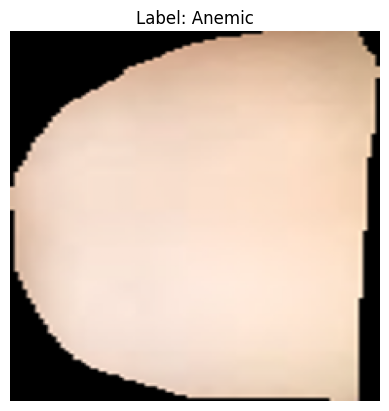

In [19]:
import matplotlib.pyplot as plt
#show image
index = 12
plt.imshow(X_train[index])
plt.title(f"Label: {'Anemic' if y_train[index] == 0 else 'Non-Anemic'}")
plt.axis('off')
plt.show()
